<a href="https://colab.research.google.com/github/Agtna/Visi-Komputer-2025-/blob/main/Jobsheet3_Teknik_Regresi_Gambar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Praktikum D1 – Regresi dari Citra Sintetis (Prediksi Radius Lingkaran)

###1)Setup & Generator Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models

# Generator 1 sample
def make_sample(img_size=64, min_r=5, max_r=20):
    r = np.random.randint(min_r, max_r + 1) # radius acak
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    cx = np.random.randint(r, img_size - r) # center-x
    cy = np.random.randint(r, img_size - r) # center-y
    cv2.circle(img, (cx, cy), r, (255,), -1) # lingkaran putih terisi
    img = (img / 255.0).astype(np.float32)
    # 3-channel biar kompatibel CNN
    img3 = np.stack([img, img, img], axis=-1)
    return img3, float(r), (cx, cy)

###2)“Tebak Apa?” — Tampilkan Contoh Gambar TANPA Label

Tugas kecil: Lihat gambar-gambar berikut. Kira-kira variabel kontinu apa yang ingin kita prediksi?

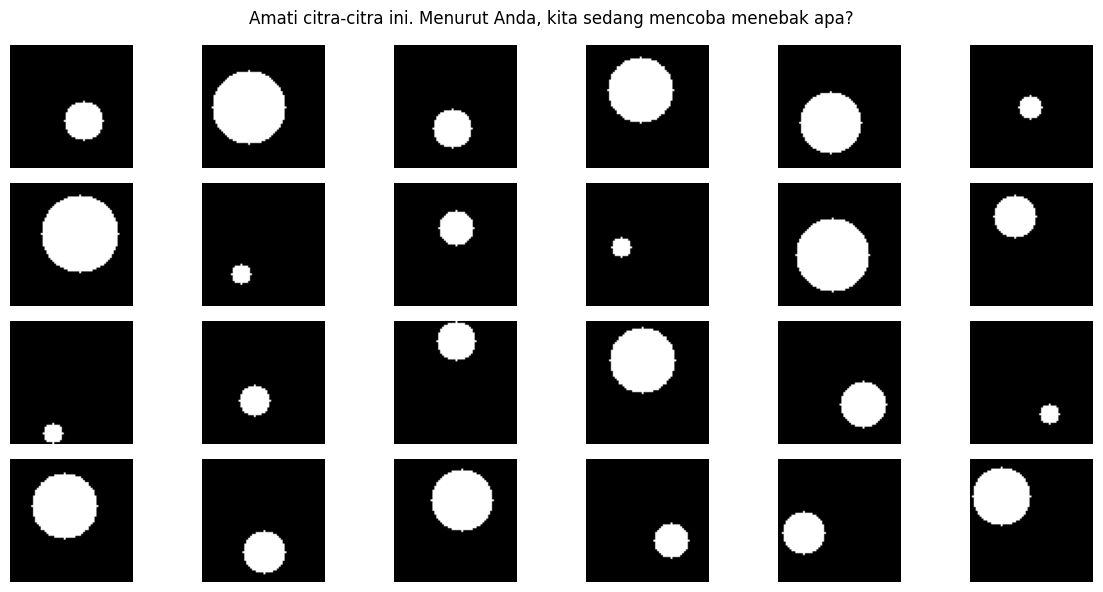

In [ ]:
# Buat 24 contoh untuk visualisasi
N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]
# Grid gambar tanpa label:
cols = 6
rows = N_show // cols
plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba menebak apa?")
plt.tight_layout()
plt.show()

Variabel kontinu yang diprediksi adalah radius(rads).

Diskusi cepat (di kelas):
1. Apakah yang berubah dari gambar ke gambar?
**jawaban :** ukuran lingkaran(besar-kecilnya), posisi pusat lingkaran yang berbeda - beda.

2. Apakah ukuran lingkaran berkaitan dengan sesuatu yang bisa “diukur” sebagai angka?
**jawaban:** iyaa, nilai radius yang disimpan di var rads
3. Apakah posisi pusat juga bisa jadi target?
**jawaban :** bisa, posisi pusat bisa dijadikan target karena merupakan nilai kontinu (koordinat x dan y).
Tetapi dalam kode dan visualisasi ini, target yang sebenarnya ingin diprediksi adalah radius lingkaran (rads), bukan posisi pusatnya.

###3)Buka Jawaban — Target yang Ingin Diprediksi

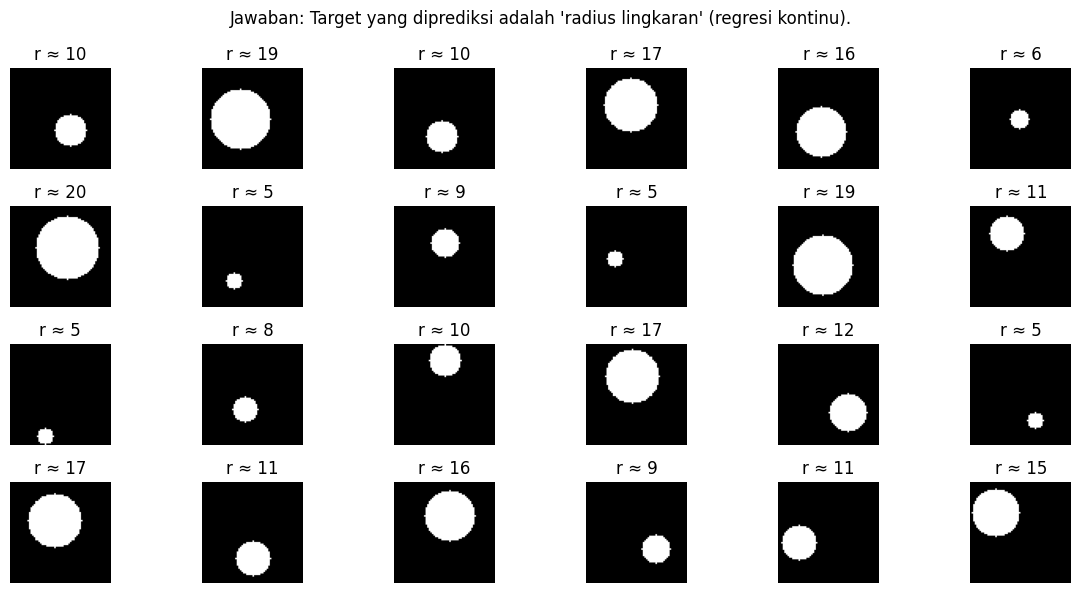

In [ ]:
# Tampilkan kembali, sekarang tampilkan radius (label) di judul tiap subplot
plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(f"r ≈ {int(rads[i])}")
    plt.axis('off')
plt.suptitle("Jawaban: Target yang diprediksi adalah 'radius lingkaran' (regresi kontinu).")
plt.tight_layout()
plt.show()

###4)(Opsional) Latih CNN Kecil untuk Memprediksi Radius

In [ ]:
# Siapkan dataset lebih besar untuk training
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Model CNN sederhana
model = models.Sequential([ layers.Input((64,64,3)),
                          layers.Conv2D(32, 3, activation='relu'), layers.MaxPooling2D(),
                          layers.Conv2D(64, 3, activation='relu'), layers.MaxPooling2D(),
                          layers.Conv2D(128, 3, activation='relu'),
                          layers.GlobalAveragePooling2D(),
                          layers.Dense(64, activation='relu'),
                          layers.Dense(1) # output regresi
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(Xtr, ytr, validation_data=(Xte, yte), epochs=12, batch_size=64, verbose=0)

# Evaluasi
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred)**2)))
r2 = r2_score(yte, y_pred)
print(f"MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
MAE=0.908 | RMSE=1.101 | R²=0.939


###Plot history & True vs Predicted:

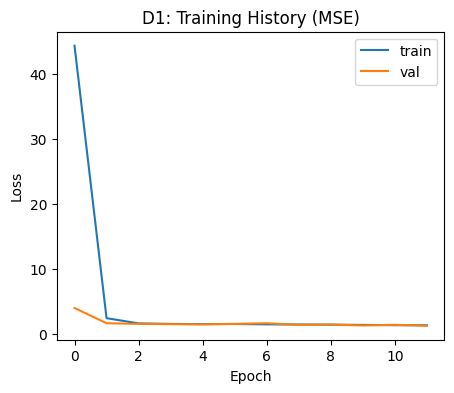

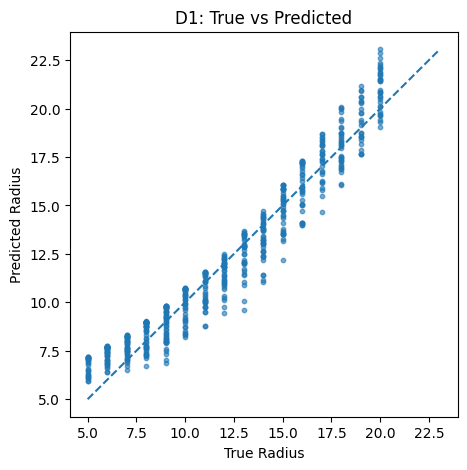

In [ ]:
# Plot loss
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

# Scatter True vs Pred
plt.figure(figsize=(5,5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius"); plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.show()

###5) Tantangan Mini (Opsional untuk Mahasiswa)

Shape X: (3000, 64, 64, 3) | Shape y: (3000, 3)
Epoch 1/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 453ms/step - loss: 644.1398 - mae: 22.6048 - val_loss: 149.6368 - val_mae: 8.7917
Epoch 2/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 427ms/step - loss: 127.7871 - mae: 8.0522 - val_loss: 58.7478 - val_mae: 6.2066
Epoch 3/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 413ms/step - loss: 61.6063 - mae: 6.3319 - val_loss: 52.9594 - val_mae: 5.7495
Epoch 4/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 415ms/step - loss: 54.7392 - mae: 5.7553 - val_loss: 49.5135 - val_mae: 5.4732
Epoch 5/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 454ms/step - loss: 52.3247 - mae: 5.5441 - val_loss: 46.8456 - val_mae: 5.1719
Epoch 6/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 415ms/step - loss: 48.8558 - mae: 5.2216 - val_loss: 45.4695 - val_mae: 4.9921
Epoch 7/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 419ms/step - loss: 47.0222 - mae: 5.0356 - val_loss: 43.8668 - val_mae: 4.9325
Epoch 8/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 475ms/step - loss: 46.0467 - mae: 5.0076 - val_loss: 43.965

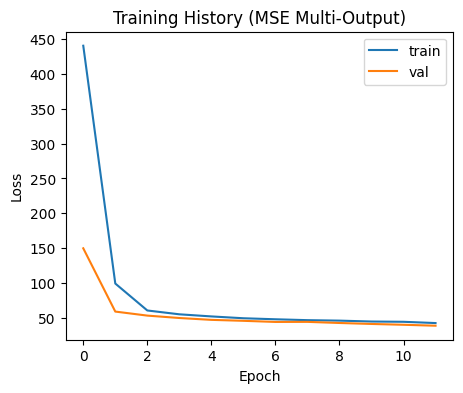

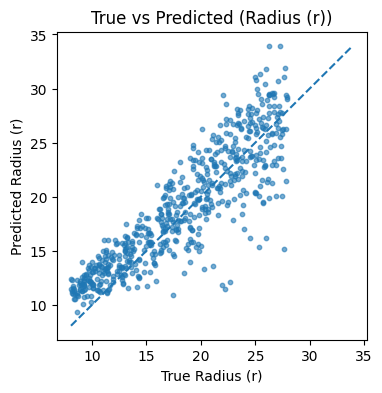

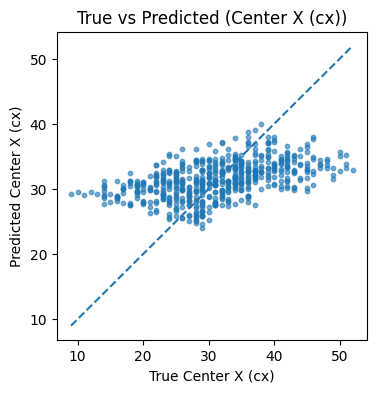

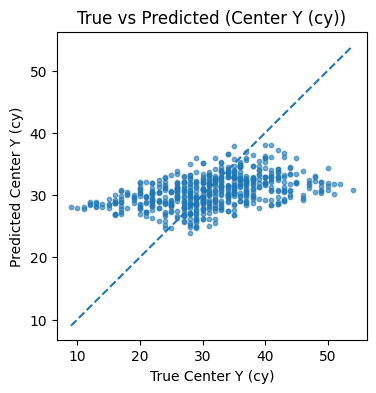

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras import models, layers

# ============================================================
# 1️⃣ Fungsi pembuat sampel data
# ============================================================
def make_sample(img_size=64):
    img = np.zeros((img_size, img_size, 3), dtype=np.uint8)

    # Pilih radius dan posisi acak (pastikan tidak keluar frame)
    r = np.random.uniform(8, 28)
    cx = np.random.randint(int(r)+1, img_size-int(r)-1)
    cy = np.random.randint(int(r)+1, img_size-int(r)-1)

    # Warna acak
    color = tuple(np.random.randint(0, 256, size=3).tolist())

    # Gambar lingkaran
    cv2.circle(img, (cx, cy), int(r), color, -1)

    # Normalisasi gambar 0–1
    img = img.astype(np.float32) / 255.0

    # Output: gambar, target (r, cx, cy), warna (hanya untuk info)
    return img, (r, cx, cy), color

# ============================================================
# 2️⃣ Siapkan dataset
# ============================================================
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])  # (img, [r,cx,cy], color)
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

print("Shape X:", X.shape, "| Shape y:", y.shape)

# Split train/test
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# ============================================================
# 3️⃣ Model CNN multi-output
# ============================================================
model = models.Sequential([
    layers.Input((64,64,3)),
    layers.Conv2D(32, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3)   # output: [r, cx, cy]
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(Xtr, ytr, validation_data=(Xte, yte),
                    epochs=12, batch_size=64, verbose=1)

# ============================================================
# 4️⃣ Evaluasi
# ============================================================
y_pred = model.predict(Xte)

mae_r = mean_absolute_error(yte[:,0], y_pred[:,0])
mae_cx = mean_absolute_error(yte[:,1], y_pred[:,1])
mae_cy = mean_absolute_error(yte[:,2], y_pred[:,2])
mae_avg = np.mean([mae_r, mae_cx, mae_cy])

r2_r = r2_score(yte[:,0], y_pred[:,0])
r2_cx = r2_score(yte[:,1], y_pred[:,1])
r2_cy = r2_score(yte[:,2], y_pred[:,2])
r2_avg = np.mean([r2_r, r2_cx, r2_cy])

dist_error = np.mean(np.linalg.norm(y_pred - yte, axis=1))

print(f"MAE_r={mae_r:.3f}, MAE_cx={mae_cx:.3f}, MAE_cy={mae_cy:.3f}, MAE_avg={mae_avg:.3f}")
print(f"R²_r={r2_r:.3f}, R²_cx={r2_cx:.3f}, R²_cy={r2_cy:.3f}, R²_avg={r2_avg:.3f}")
print(f"Mean Euclidean Distance Error = {dist_error:.3f}")

# ============================================================
# 5️⃣ Visualisasi hasil
# ============================================================
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Training History (MSE Multi-Output)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

labels = ['Radius (r)', 'Center X (cx)', 'Center Y (cy)']
for i in range(3):
    plt.figure(figsize=(4,4))
    plt.scatter(yte[:,i], y_pred[:,i], s=10, alpha=0.6)
    lims = [min(yte[:,i].min(), y_pred[:,i].min()),
            max(yte[:,i].max(), y_pred[:,i].max())]
    plt.plot(lims, lims, '--')
    plt.xlabel(f"True {labels[i]}"); plt.ylabel(f"Predicted {labels[i]}")
    plt.title(f"True vs Predicted ({labels[i]})")
    plt.show()
